In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ujipenchars2
import string
from preprocessing import DrawingToBoxScaler, VideoCreator, GradientCreator, create_gradient

In [2]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)

drawing_scaler = DrawingToBoxScaler(0, 1, 0, 1)
train = drawing_scaler.transform(train)
test = drawing_scaler.transform(test)

data = train + test
train_idx = np.array(range(len(train)))
test_idx = np.array(range(len(train), len(data)))
labels = np.array([int(drawing.label) for drawing in data], dtype=np.int8)

In [3]:
def plot_images(images: np.ndarray):
    n = len(images)
    plt.figure(figsize=(3*n, 3))

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i], cmap="binary", vmin=0, vmax=255)
        axes = plt.gca().axes
        axes.xaxis.set_ticks([])
        axes.yaxis.set_ticks([])

    plt.show()

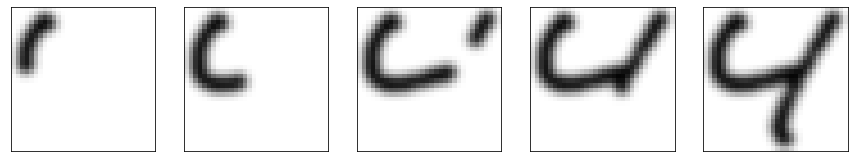

In [4]:
# Primjer izrade videa
video_creator = VideoCreator(n=5, clip=(-0.1, 1.1, -0.1, 1.1))
plot_images(video_creator.transform_one(data[8]))

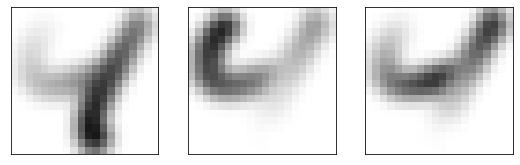

In [5]:
# Primjer gradijenta
gradient_creator = GradientCreator(
    gradients = [
        create_gradient([(0, 0), (1, 255)], 100), # bijela -> crna
        create_gradient([(0, 255), (1, 0)], 100), # crna -> bijela
        create_gradient([(0, 0), (0.5, 255), (1, 0)], 100), # bijela -> crna -> bijela
    ],
    clip=(-0.15, 1.15, -0.15, 1.15),
    size=(20, 20),
    blur_radius=1,
)
plot_images(gradient_creator.transform_one(data[8]))

In [6]:
import tensorly as tl
from tensorly.decomposition import tucker
import pandas as pd
from math import prod

# Prva dimenzija od X mora biti veličina skupa podataka
class HOSVDClassifier:
    def __init__(self):
        self.labels = None
        self.A = []
        self.k = None
        pass
    def fit(self, X: np.ndarray, y: np.ndarray):
        X = X.astype(np.float64)
        assert X.shape[0] == y.shape[0]
        self.labels, inverse = np.unique(y, return_inverse=True)
        self.k = len(self.labels)
        for i in range(self.k):
            # Tenzor za fiksni label
            tensor = X[inverse == i]
            n = tensor.shape[0]
            rank = (min(n, prod(tensor.shape[1:])),) + tensor.shape[1:] # Odrežemo prvu dimenziju
            core, factors = tl.decomposition.tucker(tensor, rank=rank)
            A = [] # A-ovi iz dekompozicije tenzora
            for i in range(n):
                a = tl.tenalg.multi_mode_dot(core[i], factors[1:])
                A.append(a / tl.norm(a))
            self.A.append(A)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = X.astype(np.float64)
        n = X.shape[0]
        squared_projection_norms = np.empty((n, self.k), dtype=np.float64) # Kvadrati normi projekcija na A-ove
        for i in range(n):
            Z = X[i]
            for j in range(self.k):
                squared_projection_norms[i, j] = sum(tl.tenalg.inner(Z, A)**2 for A in self.A[j])
        return self.labels[squared_projection_norms.argmax(axis=1)]

    def score(self, X: np.ndarray, y: np.ndarray) -> float:
        return sum(self.predict(X) == y) / X.shape[0]

In [7]:
%%time
gradients = gradient_creator.transform(data)

CPU times: user 131 ms, sys: 108 ms, total: 238 ms
Wall time: 899 ms


In [8]:
%%time
cls = HOSVDClassifier()
cls.fit(gradients[train_idx], labels[train_idx])
cls.score(gradients[test_idx], labels[test_idx])

CPU times: user 15.4 s, sys: 32.7 s, total: 48.1 s
Wall time: 5.65 s


0.9725